
# Project: Medical Appointments Data Analysis - [No-show appointments dataset]
　　　file name : noshowappointments-kagglev2-may-2016.csv

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. 
A number of characteristics about the patient are included in each row.

 Columns Description<br>
 - PatientId: Identification of a patient.<br>
 - AppointmentID: Identification of each appointment.<br>
 - Gender: Male or Female.<br>
 - AppointmentDay: The day of the actuall appointment, when they have to visit the doctor.<br>
 - ScheduledDay: The day someone called or registered the appointment, this is before appointment of course.<br>
 - Age: How old is the patient.<br>
 - Neighbourhood: Where the appointment takes place.<br>
 - Scholarship: True of False, indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.<br>
 - Hipertension: True or False.<br>
 - Diabetes: True or False.<br>
 - Alcoholism: True or False.<br>
 - Handcap: True or False.<br>
 - SMS_received: 1 or more messages sent to the patient.<br>
 - No-show: True (if the patient did not show up), or False (if the patient did show up).<br>


### Question(s) for Analysis

In this report, I will examine the following questions<br>
<br>
Q1. Is there a correlation between the number of days from ScheduledDay to AppointmentDay and "No-Show"?<br>
Q2. Does SMS communication with patients about bookings affect the "No-Show" percentage in Q1?<br>
Q3. Do diseases of "Hipertension", "Diabetes", "Alcoholism" affect the percentage of "No-show"?<br>


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling
<br>
First, In this section of the report, I will load in the data, check for cleanliness, and then trim and clean my dataset for analysis.<br>


### General Properties


In [2]:
# Reading csv data file
df = pd.read_csv('./Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')

In [3]:
# Checking the first few lines of data
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Checking the number of rows / columns
df.shape

(110527, 14)

In [5]:
# Checking the summary of data type, number, and missing value of each item
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
# Checking for duplicate data rows
sum(df.duplicated())

0

In [7]:
# Checking if there are some unique values ​​such as column'Gender' as expected
target_columns = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
for column in target_columns:
    print(df[column].unique())

['F' 'M']
[ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35  20
  26  34  33  16  42   5  47  17  41  44  37  24  66  77  81  70  53  75
  73  52  74  43  89  57  14   9  48  83  72  25  80  87  88  84  82  90
  94  86  91  98  92  96  93  95  97 102 115 100  99  -1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1 2 3 4]
[0 1]
['No' 'Yes']



### Data Cleaning
<br>
Based on the result of checking the cleanliness of the data, I'll perform the following data cleaning for the investigation.<br>
<br>
1. In this data, there is no missing data and duplicated data in all items, and it was not necessary to deal with them.<br>
2. There is an outlier of -1 in Age this time, but since it is an item that is not used for investigation, I won't deal with it.<br>
3. The following items not used in this survey will be deleted to simplify the survey.(PatientId, AppointmentID, Gender, Age, Neighbourhood, Scholarship)<br>
4. Convert ScheduledDay and AppointmentDay to date data type and add item "Diff_Day" that sets the number of days difference between the two dates.<br>
5. Convert Hipertension, Diabetes, Alcoholism, SMS_received to Boolean data types for ease of investigation.([1]→true, [0]→false)<br>
6. Convert No-show to Boolean data type for ease of investigation.([No]→true, [Yes]→false)<br>


In [8]:
# (#3) Dropping columns['PatientId', 'AppointmentID', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Handcap']
df.drop(['PatientId', 'AppointmentID', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Handcap'], axis=1, inplace=True)
df.head(1)

,ScheduledDay,AppointmentDay,Hipertension,Diabetes,Alcoholism,SMS_received,No-show
0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,1,0,0,0,No


The column was deleted correctly

In [9]:
# Converting 'ScheduledDay' and 'AppointmentDay' to date datatype
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'].str[:10], format='%Y-%m-%d')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'].str[:10], format='%Y-%m-%d')
df.head(1)

,ScheduledDay,AppointmentDay,Hipertension,Diabetes,Alcoholism,SMS_received,No-show
0,2016-04-29,2016-04-29,1,0,0,0,No


In [10]:
# Checking the data types of'ScheduledDay'and'AppointmentDay'
print(df.ScheduledDay.dtype, df.AppointmentDay.dtype)

datetime64[ns] datetime64[ns]


'Scheduled Date' and'AppointmentDay' have been converted to DateTime type

In [11]:
# adding column "Diff_Day" that sets the number of days difference between 'AppointmentDay' and 'ScheduledDay'.
df['Diff_Day'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df.head(1)

,ScheduledDay,AppointmentDay,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,Diff_Day
0,2016-04-29,2016-04-29,1,0,0,0,No,0


In [12]:
# Checking the describe of'Diff_Day'
df.Diff_Day.describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Diff_Day, dtype: float64

'Diff_Day' has been added properly.<br>
However, 'Diff_day' should be all positive, but there seems to be negative outliers, so I'll check it.

In [13]:
# Checking the data with negative value for'Diff_Day'
df[df['Diff_Day'] < 0]

,ScheduledDay,AppointmentDay,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,Diff_Day
27033,2016-05-10,2016-05-09,0,0,0,0,Yes,-1
55226,2016-05-18,2016-05-17,0,0,0,0,Yes,-1
64175,2016-05-05,2016-05-04,0,0,0,0,Yes,-1
71533,2016-05-11,2016-05-05,0,0,0,0,Yes,-6
72362,2016-05-04,2016-05-03,0,0,0,0,Yes,-1


I can't judge from the data whether I just entered'ScheduledDay'and'AppointmentDay' in the opposite direction artificially, so I will delete it.

In [14]:
# Deleting data with negative value for'Diff_Day'and recheck
df.drop(df[df['Diff_Day'] < 0].index, axis=0, inplace=True)
df[df['Diff_Day'] < 0]

,ScheduledDay,AppointmentDay,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,Diff_Day


It was confirmed that the data with a negative value of'Diff_Day'was deleted.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 8 columns):
ScheduledDay      110522 non-null datetime64[ns]
AppointmentDay    110522 non-null datetime64[ns]
Hipertension      110522 non-null int64
Diabetes          110522 non-null int64
Alcoholism        110522 non-null int64
SMS_received      110522 non-null int64
No-show           110522 non-null object
Diff_Day          110522 non-null int64
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 7.6+ MB


In [16]:
# Checking the current value distribution before converting the value of 'No-show'('Yes'/'No')
df['No-show'].value_counts()

No     88208
Yes    22314
Name: No-show, dtype: int64

In [17]:
# Convert values ​​so that'No-show can be combined with other columns and converted to bool type ('yes' → 1,'No' → 0)
df['No-show'] = df['No-show'].mask(df['No-show'] == 'Yes', 1)
df['No-show'] = df['No-show'].mask(df['No-show'] == 'No', 0)
df['No-show'].value_counts()


0    88208
1    22314
Name: No-show, dtype: int64

I Confirmed that the value of 'No-show' has been changed appropriately ('yes' → 1,'No' → 0)

In [18]:
# Converting Hipertension, Diabetes, Alcoholism, SMS_received, No-show to Boolean data types.([1]→true, [0]→false)
boolColumns = ['Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'No-show']
df[boolColumns] = df[boolColumns].astype('bool')
df[boolColumns].dtypes


Hipertension    bool
Diabetes        bool
Alcoholism      bool
SMS_received    bool
No-show         bool
dtype: object

I Confirmed that the datatype of Hipertension, Diabetes, Alcoholism, SMS_received, 'No-show has been changed appropriately ('yes' → 1,'No' → 0)

In [19]:
# Final confirmation of data cleaning status
df.head(5)

,ScheduledDay,AppointmentDay,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,Diff_Day
0,2016-04-29,2016-04-29,True,False,False,False,False,0
1,2016-04-29,2016-04-29,False,False,False,False,False,0
2,2016-04-29,2016-04-29,False,False,False,False,False,0
3,2016-04-29,2016-04-29,False,False,False,False,False,0
4,2016-04-29,2016-04-29,True,True,False,False,False,0


<a id='eda'></a>
## Exploratory Data Analysis


### Question 1 : Is there a correlation between Diff_Day(the number of days from ScheduledDay to AppointmentDay) and "No-Show"?

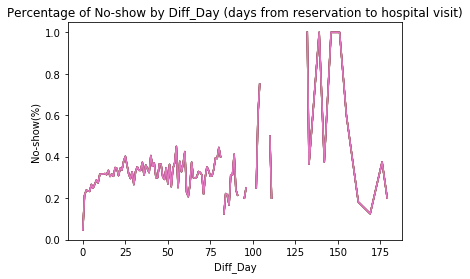

In [20]:
# Viewing percentage plot of 'Now -show' per 'Diff_Day'(OVERALL)
(df[df['No-show']].groupby(['Diff_Day']).count() / df.groupby(['Diff_Day']).count()).plot(kind='line', legend=False)
plt.title('Percentage of No-show by Diff_Day (days from reservation to hospital visit)')
plt.xlabel('Diff_Day')
plt.ylabel('No-show(%)')
plt.show()

Overall, it seems that there is no correlation, but until Diff_Day is 25th, No-show increases as Diff_Day increases, and it seems that there is a correlation.

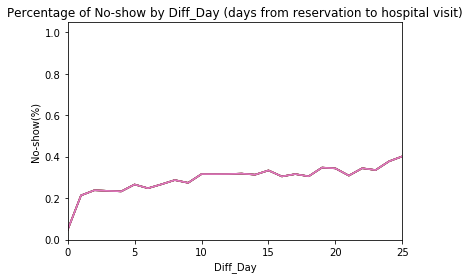

In [21]:
# Viewing percentage plot of 'Now -show' per 'Diff_Day'(Diff_Day=0～25)
(df[df['No-show']].groupby(['Diff_Day']).count() / df.groupby(['Diff_Day']).count()).plot(kind='line', legend=False, xlim=[0,25])
plt.title('Percentage of No-show by Diff_Day (days from reservation to hospital visit)')
plt.xlabel('Diff_Day')
plt.ylabel('No-show(%)')
plt.show()

After all, Diff_Day seems to be correlated until about the 25th day.
It seems that it has become that Patients tend to gradually forget to make reservations until the 25th day after making a reservation, and after that, whether the patient notices is constant or random due to luck or some other reason. 

### Question 2 : Does SMS communication with patients about bookings affect the "No-Show" percentage in Q1?
<br>
I’ll Check if the trend changes depending on SMS_received in "Diff_Day  <= 25 "

In [22]:
# Preparing each DF with "SMS_Received = True / Flase"
df_SmsTrue = df[df['SMS_received'] == True]
df_SmsFalse = df[df['SMS_received'] == False]


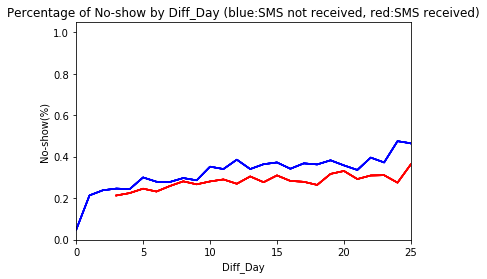

In [23]:
# Viewing percentage plot of 'Now -show' per 'Diff_Day'(Diff_Day=0～25) with "SMS_Received = True / Flase"
fig, ax = plt.subplots(facecolor="w")

ax.plot(df_SmsTrue[df_SmsTrue['No-show']].groupby(['Diff_Day']).count() / df_SmsTrue.groupby(['Diff_Day']).count(), color='red')
ax.plot(df_SmsFalse[df_SmsFalse['No-show']].groupby(['Diff_Day']).count() / df_SmsFalse.groupby(['Diff_Day']).count(), color='blue')
#ax.plot(df_SmsTrue[df_SmsTrue['No-show']].groupby(['Diff_Day']).count() / df_SmsTrue.groupby(['Diff_Day']).count(), color='red', label="SMS receive")
#ax.plot(df_SmsFalse[df_SmsFalse['No-show']].groupby(['Diff_Day']).count() / df_SmsFalse.groupby(['Diff_Day']).count(), color='blue', label="SMS not receive")

ax.set_title('Percentage of No-show by Diff_Day (blue:SMS not received, red:SMS received)')
ax.set_xlabel('Diff_Day')
ax.set_ylabel('No-show(%)')
ax.set_xlim([0,25])
#ax.legend(['SMS receive', 'SMS not receive'])
#ax.legend()
plt.show()


Looking at the percentage of No-shows when SMS was received and when it was not received, the percentage of No-shows when SMS was received remained lower.
It was confirmed that SMS reception has the effect of improving No-show.

### Question 3 : Do diseases of 'Hipertension', 'Diabetes', 'Alcoholism' affect the percentage of "No-show"?

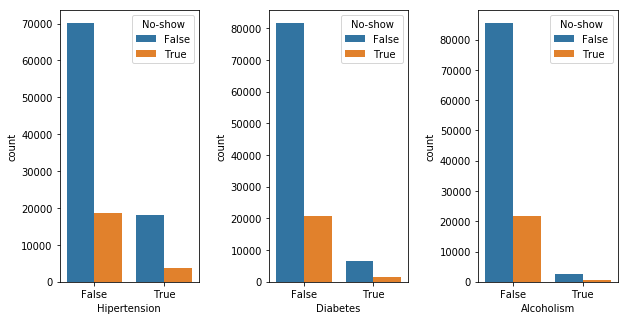

In [64]:
# plotting deseases against no show
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.subplot(1,3,1)
sns.countplot(x = 'Hipertension', data = df, hue= 'No-show')
plt.subplot(1,3,2)
sns.countplot(x = 'Diabetes', data = df, hue= 'No-show')
plt.subplot(1,3,3)
sns.countplot(x = 'Alcoholism', data = df, hue= 'No-show')
plt.show()

In [65]:
# Confirming About the case of Hipertension
# Percentage of No-show among people with Not Hipertension
y1 = ((df['Hipertension'] == False) & (df['No-show'])).sum() / (df['Hipertension'] == False).sum()
# Percentage of No-show among people with Hipertension
y2 = ((df['Hipertension']) & (df['No-show'])).sum() / (df['Hipertension']).sum()
print(y1, y2)

0.208992234082 0.173019586258


In [66]:
# Confirming About the case of Diabetes
# Percentage of No-show among people with Not Diabetes
y1 = ((df['Diabetes'] == False) & (df['No-show'])).sum() / (df['Diabetes'] == False).sum()
# Percentage of No-show among people with Diabetes
y2 = ((df['Diabetes']) & (df['No-show'])).sum() / (df['Diabetes']).sum()
print(y1, y2)

0.203589428635 0.180032733224


In [67]:
# Confirming About the case of Alcoholism
# Percentage of No-show among people with Not Alcoholism
y1 = ((df['Alcoholism'] == False) & (df['No-show'])).sum() / (df['Alcoholism'] == False).sum()
# Percentage of No-show among people with Alcoholism
y2 = ((df['Alcoholism']) & (df['No-show'])).sum() / (df['Alcoholism']).sum()
print(y1, y2)

0.201909258879 0.201488095238


diseases can affect your appearance in hospital appointments.
If they have hipertension or diabetes, the tendency for No-show appears to be low.
In the case of alcoholism, the tendency of No-show does not seem to change.

<a id='conclusions'></a>
## Conclusions

Q1. Is there a correlation between the number of days from ScheduledDay to AppointmentDay and "No-Show"?<br>

- Overall, it seems that there is no correlation, but until Diff_Day is 25th, No-show increases as Diff_Day increases, and it seems that there is a correlation.
- After all, Diff_Day seems to be correlated until about the 25th day. It seems that it has become that Patients tend to gradually forget to make reservations until the 25th day after making a reservation, and after that, whether the patient notices is constant or random due to luck or some other reason.

Q2. Does SMS communication with patients about bookings affect the "No-Show" percentage in Q1?<br>

- Looking at the percentage of No-shows when SMS was received and when it was not received, the percentage of No-shows when SMS was received remained lower. It was confirmed that SMS reception has the effect of improving No-show.

Q3. Do diseases of "Hipertension", "Diabetes", "Alcoholism" affect the percentage of "No-show"?<br>

- diseases can affect your appearance in hospital appointments.
- If they have hipertension or diabetes, the tendency for No-show appears to be low.
- In the case of alcoholism, the tendency of No-show does not seem to change.


In [ ]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])